In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use("science")

from astropy.modeling.models import BlackBody
from astropy import units as u

from astropy.visualization import quantity_support
quantity_support()

from specutils import Spectrum1D, SpectralRegion

DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data/Szkody APO Spectra"
os.listdir(DATA_DIR)

['f24s.fits', 'f23s.fits', 'combined-spectrum']

In [11]:
import pandas as pd

USE_SINGLE_SPECTRUM = False
spec: Spectrum1D = None

if USE_SINGLE_SPECTRUM:
	print("Single spectrum")
	fitsPath = os.path.join(DATA_DIR, os.listdir(DATA_DIR)[0])
	spec = Spectrum1D.read(fitsPath)
else:
	print("Using spectra sum")
	
	combinedSpecDir = os.path.join(DATA_DIR, "combined-spectrum")
	combinedSpecPath = os.path.join(combinedSpecDir, "combined.fits")

	individualSpecDir = os.path.join(DATA_DIR, "single-spectra")
	os.makedirs(individualSpecDir, exist_ok=True)
	
	for f in os.listdir(DATA_DIR):
		if os.path.isdir(os.path.join(DATA_DIR, f)):
			continue

		s = Spectrum1D.read(os.path.join(DATA_DIR, f))

		# writing out csv files for use in PyHammer
		sDf = pd.DataFrame(data={"wavelength": s.wavelength, "flux": s.flux})
		sDf.to_csv(os.path.join(individualSpecDir, f.replace(".fits", ".csv")), index=False, header=False)

		if spec is None:
			spec = s
		else:
			spec += s

	os.makedirs(combinedSpecDir, exist_ok=True)
	spec.write(combinedSpecPath, format='wcs1d-fits', overwrite=True)

	manualSpecDf = pd.DataFrame(data={"wavelength": spec.wavelength, "flux": spec.flux})
	manualSpecDf.to_csv(os.path.join(combinedSpecDir, "combined-spec.csv"), index=False, header=False)

Using spectra sum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# Spectra Phase

Determining at which phase each spectrum was taken, to determine contribution from individual components.

In [45]:
# read ZTF data for timing data; only need one to read in and plot in phase
# using ZTF:r data since starspot is more obvious in this passband
from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time

rData = Table.read("/home/ramon/uanl/Tesis/Backup Data/IRSA/rel-zr-flux.ecsv")

ztfPeriod = (0.1667834993*2) * u.day # second harmonic
t0_supconj = (-0.03754) * u.day

ztfTs = TimeSeries(time=Time(val=rData['hjd'], scale='utc', format='jd'), data={'mag': rData['mag'], 'flux': rData['flux']})
foldedZtfTs = ztfTs.fold(period=ztfPeriod, epoch_time=Time(t0_supconj, format='jd', scale='utc'), normalize_phase=True)
foldedZtfTs

time,mag,flux
,mag,
float64,float64,float64
-0.052528259788745306,16.9123917,1.5802176926680154
-0.08918407399045733,16.8072433,1.7409098399289054
-0.3191965016461648,16.7090816,1.9056404378419571
-0.18916576852369585,16.6873932,1.9440897925134992
-0.09854087866402873,16.8001652,1.752296203402617
-0.19302898105223534,16.6898041,1.9397776897096966
-0.09443599312072036,16.8298531,1.7050313159626551
-0.08872593825454944,16.8058014,1.7432233719442416


In [62]:
from astropy.coordinates import EarthLocation, SkyCoord

apoLoc = EarthLocation.of_site("Apache Point Observatory")
atoCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
apoLoc, atoCoord

(<EarthLocation (-1463969.30185172, -5166673.34223433, 3434985.71204565) m>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (339.94690379, 45.14639753)>)

/home/ramon/.local/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


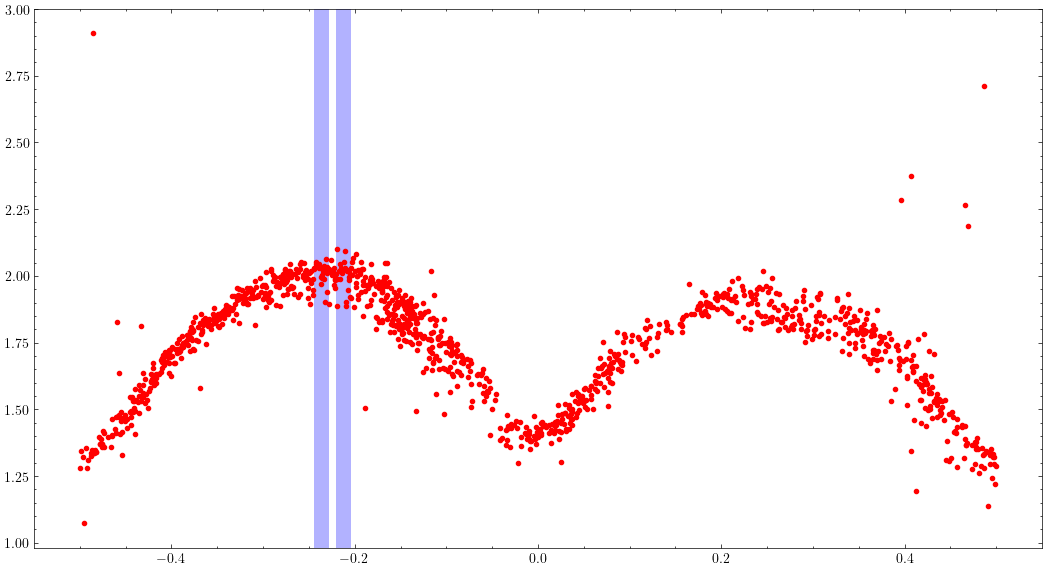

In [63]:
import matplotlib.pyplot as plt
from astropy.io import fits

plt.figure(figsize=(13, 7))
plt.plot(foldedZtfTs.time, foldedZtfTs['flux'], marker='.', linestyle='none', color='red')

for f in os.listdir(DATA_DIR):
	if os.path.isdir(os.path.join(DATA_DIR, f)):
		continue
	
	specHdul = fits.open(os.path.join(DATA_DIR, f))[0]
	specUtcTimeObs = Time(specHdul.header['DATE-OBS'], scale='utc') + (specHdul.header['UTC-TAI']*u.second)
	specTimeHjd = specUtcTimeObs + specUtcTimeObs.light_travel_time(atoCoord, kind='heliocentric', location=apoLoc)
	startObsTime = specTimeHjd - (specHdul.header['EXPTIME']*u.second)

	specTs = TimeSeries(time=[startObsTime, specUtcTimeObs])
	foldedSpecTs = specTs.fold(period=ztfPeriod, epoch_time=Time(t0_supconj, format='jd', scale='utc'), normalize_phase=True)

	plt.axvspan(foldedSpecTs.time[0], foldedSpecTs.time[-1], color='blue', alpha=0.3, lw=0)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


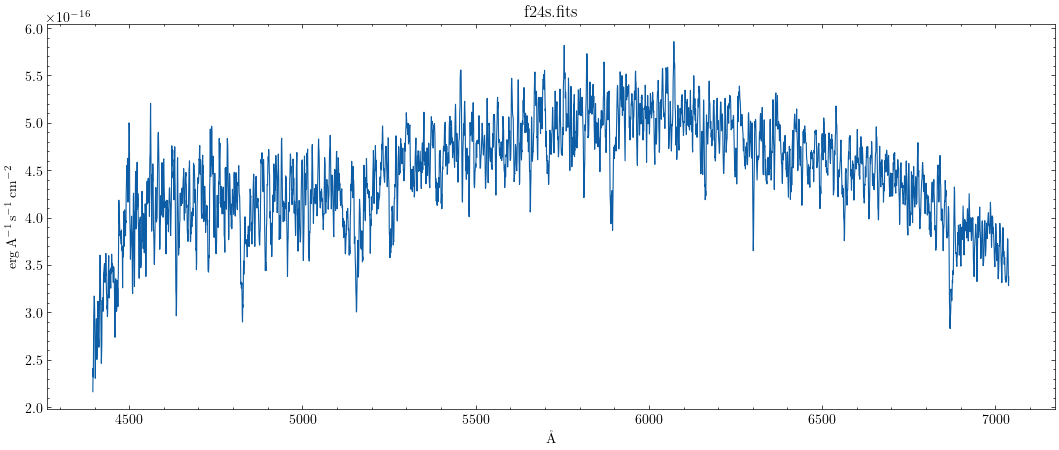

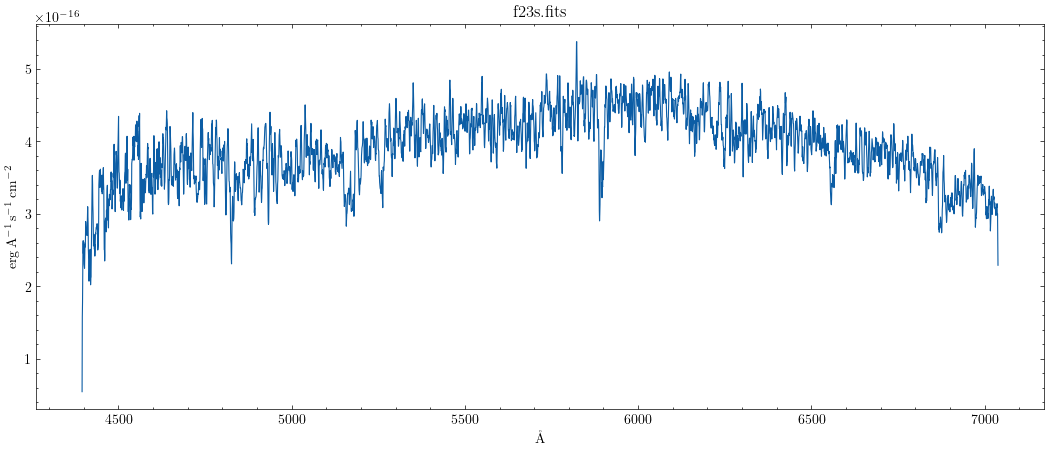

In [27]:
for f in os.listdir(DATA_DIR):
	if os.path.isdir(os.path.join(DATA_DIR, f)):
		continue

	s = Spectrum1D.read(os.path.join(DATA_DIR, f))
	plt.figure(figsize=(13, 5))
	plt.plot(s.spectral_axis, s.flux, linewidth=0.8)
	plt.title(f)

Text(0.5, 1.0, 'Sum of individual spectra')

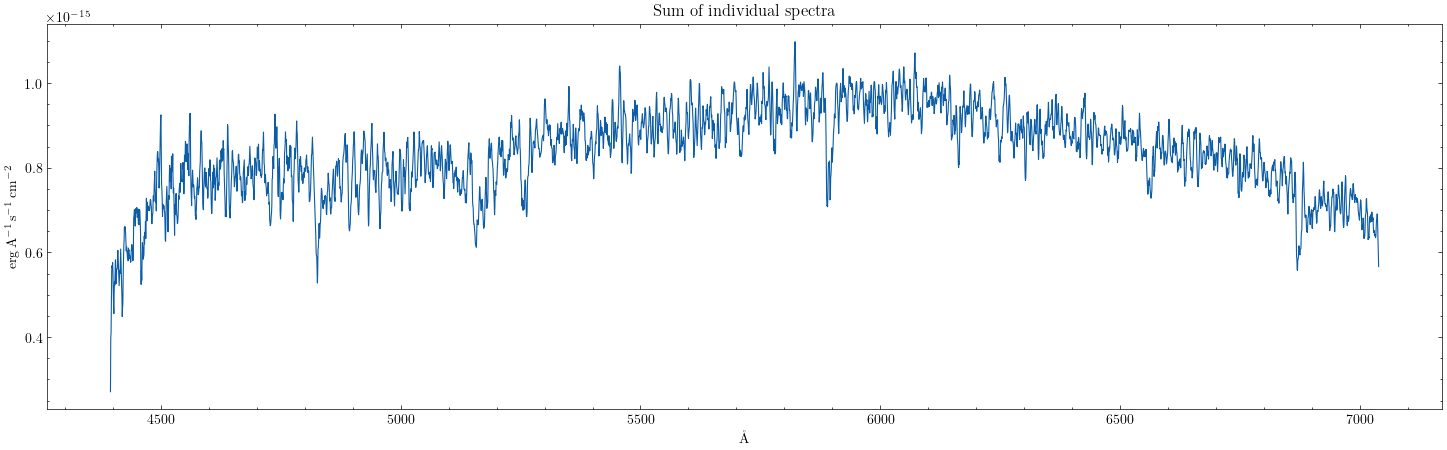

In [18]:
plt.figure(figsize=(18, 5))
plt.plot(spec.spectral_axis, spec.flux, linewidth=0.8)
plt.title("Sum of individual spectra")

# Extinction Analysis

In [ ]:
# blackbody test
import numpy as np
from astropy.modeling.models import BlackBody
import astropy.units as u

# wavelengths and spectrum are 1D arrays
# wavelengths between 1000 and 30000 A
wavelengths = np.logspace(np.log10(1000), np.log10(3e4), num=1000)*u.AA
bb_lam = BlackBody(10000*u.K, scale=1.0 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
spectrum = bb_lam(wavelengths)

# Continuum Fitting and Spectral Line Analysis

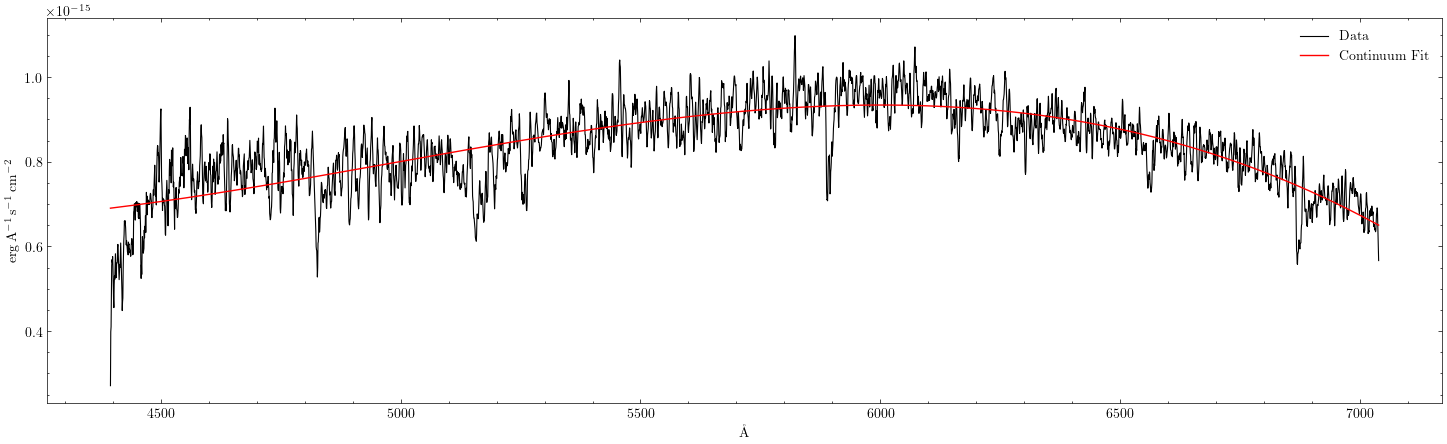

In [5]:
from specutils.fitting import fit_generic_continuum

generif_fit = fit_generic_continuum(spec)
specContinuum = generif_fit(spec.spectral_axis)

plt.figure(figsize=(18, 5))
plt.plot(spec.spectral_axis, spec.flux, linewidth=0.8, label='Data', color='black')
plt.plot(spec.spectral_axis, specContinuum, label='Continuum Fit', color='red')
plt.legend()

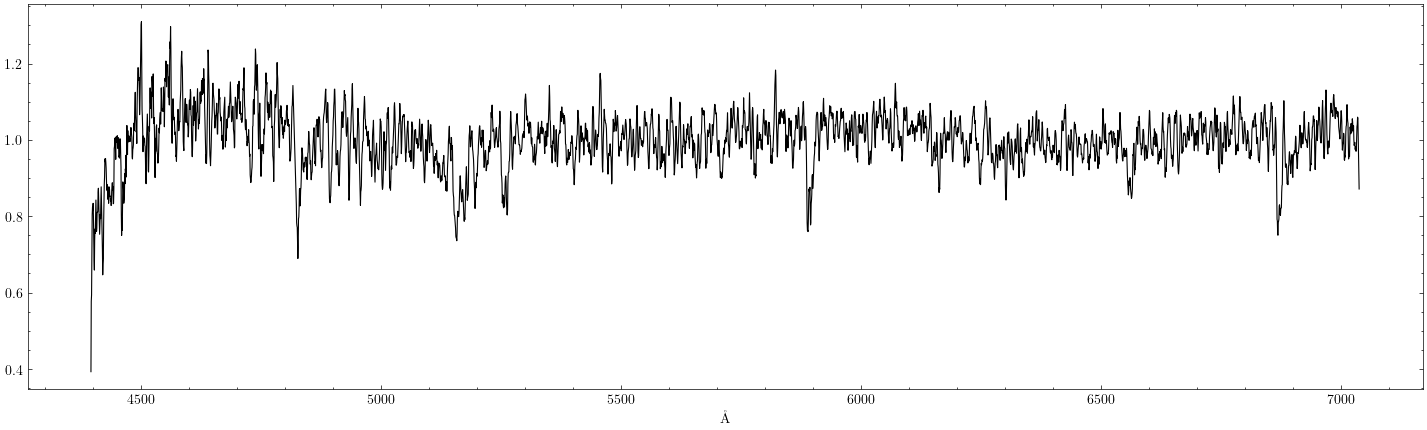

In [8]:
spec_norm = spec / specContinuum

plt.figure(figsize=(18, 5))
plt.plot(spec_norm.spectral_axis, spec_norm.flux, linewidth=0.8, color='black')

Spectrum1D (length=4095)
flux:             [ 0.39278, ..., 0.87132 ],  mean=1.0
spectral axis:    [ 4395.2 Angstrom, ..., 7038.7 Angstrom ],  mean=5716.9 Angstrom
uncertainty:      [ StdDevUncertainty(0.04756255), ..., StdDevUncertainty(0.04756255) ]



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
4399.688417280887,emission,7
4405.499761721328,emission,16
4410.665401223942,emission,24
4416.476745664383,emission,33
4450.053402431375,emission,85
4500.418387581862,emission,163
4940.143450241886,emission,844
5159.683129102985,emission,1184


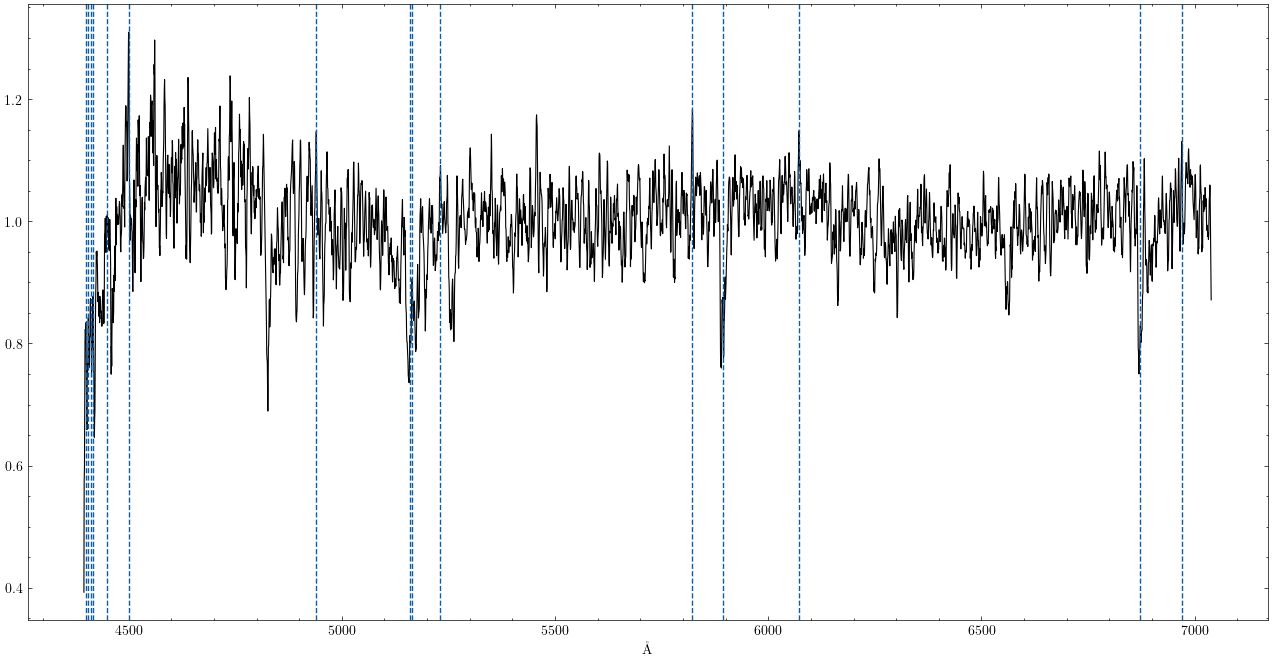

In [10]:
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import find_lines_threshold, find_lines_derivative

noise_region = SpectralRegion(5500*u.AA, 5800*u.AA)
spectrumNoise = noise_region_uncertainty(spec_norm, noise_region)
print(spectrumNoise)

lines = find_lines_threshold(spectrumNoise, noise_factor=17)  
# lines = find_lines_derivative(spec_norm, flux_threshold=1.1)

plt.figure(figsize=(16, 8))
plt.plot(spec_norm.spectral_axis, spec_norm.flux, linewidth=0.8, color='black')

for row in lines:
	plt.axvline(row['line_center'].value, linestyle='dashed')
lines

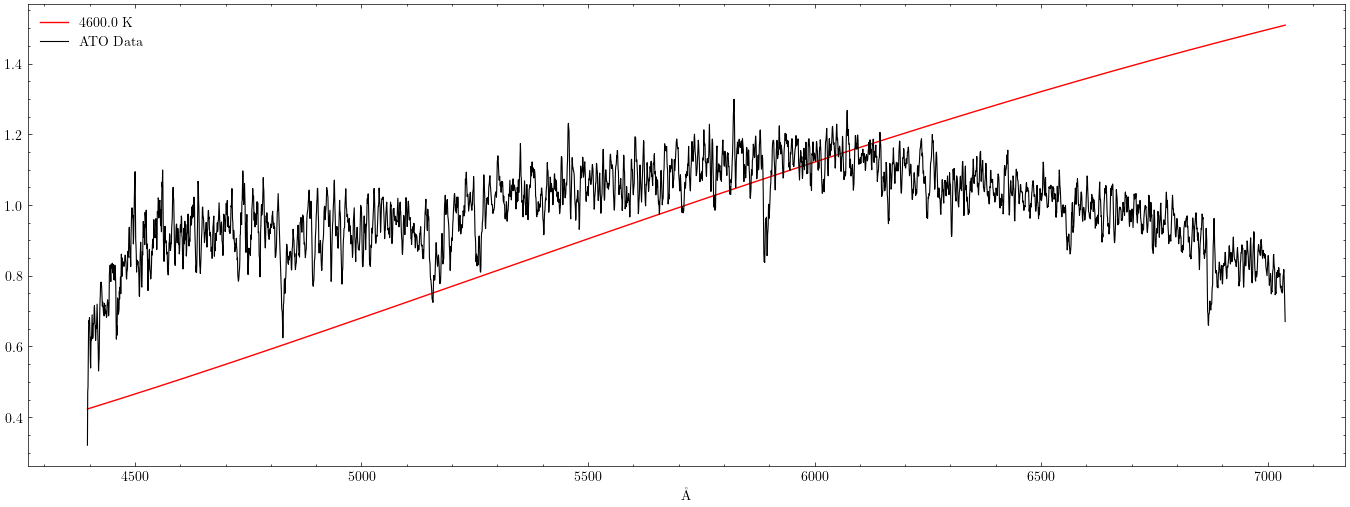

In [65]:
temperature = 4600*u.K
bb = BlackBody(temperature=temperature)
flux = bb(spec.spectral_axis)

plt.figure(figsize=(17, 6))
plt.plot(spec.spectral_axis, flux / np.median(flux), label=temperature, color='red')
plt.plot(spec.spectral_axis, spec.flux / np.median(spec.flux), label='ATO Data',color='black', lw=0.8)
plt.legend()
plt.show()